In [2]:
%cd ~/repo/protein-transfer

/home/t-fli/repo/protein-transfer


In [3]:
%load_ext blackcellmagic

In [4]:
encoder_name = "esm1_t6_43M_UR50S"
# encoder_name = "esm1_t12_85M_UR50S"
# encoder_name = "esm1_t34_670M_UR50S"
 #encoder_name = "esm1b_t33_650M_UR50S"
    

In [5]:
import torch

# Load ESM-1b model
original_model, alphabet = torch.hub.load(
            "facebookresearch/esm:main", model=encoder_name
        )
batch_converter = alphabet.get_batch_converter()
data = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG")
]
batch_labels, batch_strs, batch_tokens = batch_converter(data)

original_model.eval()
with torch.no_grad():
    original_results = original_model(batch_tokens, repr_layers=[6], return_contacts=False)
original_reps = original_results["representations"][6].numpy().mean(axis=1).flatten()

Using cache found in /home/t-fli/.cache/torch/hub/facebookresearch_esm_main


In [ ]:
for k, p in original_model.state_dict().items():
    print(f"{k}: dim {p.dim()}")

In [6]:
import torch
from torch.nn import Parameter  
from torch.nn.init import xavier_uniform_, xavier_normal_, kaiming_uniform_, uniform_, normal_, constant_, _calculate_fan_in_and_fan_out

In [21]:
import math


def cal_bound(model: torch.nn.Module, layer_name: str):
    """Return bound for reinit given model and layer name"""
    assert "bias" in layer_name, f"no bias in {layer_name}"
    fan_in, _ = _calculate_fan_in_and_fan_out(model.state_dict()[layer_name.replace("bias", "weight")])
    return 1 / math.sqrt(fan_in) if fan_in > 0 else 0


In [7]:
import copy
import numpy as np

def reset_parameters(model, encoder_name):
    """Initiate parameters in the transformer model."""

    for layer_name, p in model.state_dict().items():
        # what esm1b and esm1 have in common
        if "_proj" in layer_name:
            if "weight" in layer_name:
                if "out" in layer_name:
                    xavier_uniform_(p)
                else:
                    xavier_uniform_(p, gain=1 / math.sqrt(2))
            elif "bias" in layer_name:
                if "out" in layer_name:
                    constant_(p, 0.0)
                else:
                    bound = cal_bound(model=model, layer_name=layer_name)
                    uniform_(p, -bound, bound)

        # esm1b enced up using LayerNorm so the same    
        if "layer_norm" in layer_name:
            if "weight" in layer_name:
                Parameter(torch.ones_like(p))
            elif "bias" in layer_name:
                Parameter(torch.zeros_like(p))
        
        if ("layers" and "fc" in layer_name) or ("contact_head" in layer_name):
            if "weight" in layer_name:
                kaiming_uniform_(p, a=math.sqrt(5))
            elif "bias" in layer_name:
                bound = cal_bound(model=model, layer_name=layer_name)
                uniform_(p, -bound, bound)
        
        if "esm1b_" in encoder_name:
            
            if "embed_positions" in layer_name:
                normal_(p)

            if layer_name == "lm_head.weight":
                xavier_uniform_(p)
            
            if layer_name == "lm_head.bias" or "lm_head.layer_norm.bias":
                Parameter(torch.zeros_like(p))

            if "dense" in layer_name:
                if "weight" in layer_name:
                    kaiming_uniform_(p, a=math.sqrt(5))
                elif "bias" in layer_name:
                    bound = cal_bound(model=model, layer_name=layer_name)
                    uniform_(p, -bound, bound)
        
        elif "esm1_" and "bias_" in encoder_name:
            xavier_normal_(p)
    
    return model

def resample_parameters(model, encoder_name, embed_dim):
    for layer_name, p in model.state_dict().items():
        # if "layers" or "contact_head" or "embed_positions" or ".weight" or "emb_layer_norm" in layer_name:
        if ("embed_tokens" not in layer_name) and ("embed_out" not in layer_name) and ("_float_tensor" not in layer_name):
            print(f"{layer_name}: {p.shape}")
            
            if len(p.shape) == 1:
                p = p[torch.randperm(p.shape[0])]
                """
                layers.n.self_attn.k_proj.bias: torch.Size([embed_dim])
                layers.n.self_attn.v_proj.bias: torch.Size([embed_dim])
                layers.n.self_attn.q_proj.bias: torch.Size([embed_dim])
                layers.n.self_attn.out_proj.bias: torch.Size([embed_dim])
                layers.n.self_attn_layer_norm.weight: torch.Size([embed_dim])
                layers.n.self_attn_layer_norm.bias: torch.Size([embed_dim])
                layers.n.fc1.bias: torch.Size([fc_dim])
                layers.n.fc2.bias: torch.Size([embed_dim])
                layers.n.final_layer_norm.weight: torch.Size([embed_dim])
                layers.n.final_layer_norm.bias: torch.Size([embed_dim])
                """
            elif 1 in p.shape:
                """
                layers.n.self_attn.bias_k: torch.Size([1, 1, embed_dim])
                layers.n.self_attn.bias_v: torch.Size([1, 1, embed_dim])
                contact_head.regression.weight: torch.Size([1, reg_dim])
                """
                if "bias_" in layer_name:
                    p = p[:, :, torch.randperm(embed_dim)]
                elif "regression.weight" in layer_name:
                    p = p[:, torch.randperm(p.shape[-1])]
            
            elif "k_proj.weight" or "q_proj.weight" or "fc1.weight" in layer_name:
                if "0" in layer_name:
                    print(f"p before:\n{p}")
                p = p[torch.randperm(p.shape[0]),:]
                print(f"p after:\n{p}")
                """
                layers.n.self_attn.k_proj.weight: torch.Size([embed_dim, embed_dim])
                layers.n.self_attn.v_proj.weight: torch.Size([embed_dim, embed_dim])
                layers.n.self_attn.q_proj.weight: torch.Size([embed_dim, embed_dim])
                layers.n.self_attn.out_proj.weight: torch.Size([embed_dim, embed_dim])
                layers.n.fc1.weight: torch.Size([fc_dim, embed_dim])
                layers.n.fc2.weight: torch.Size([embed_dim, fc_dim])
                """
            elif "v_proj.weight" or "out_proj.weight" or "fc2.weight" in layer_name:
                if "0" in layer_name:
                    print(f"p before:\n{p}")
                p = p[:, torch.randperm(p.shape[1])]
                if "0" in layer_name:
                    print(f"p after:\n{p}")

            """
            Find out which dim = embed_dim
            and shuffle along the dim
            t=torch.tensor([[1,2],[3,4]])
            r=torch.randperm(2)
            c=torch.randperm(2)
            t=t[r[:, None], c]

            # With view
            idx = torch.randperm(t.nelement())
            t = t.view(-1)[idx].view(t.size())
            """
            
    return model

In [6]:
t=torch.tensor([[[1,2,3]]])
t, t.shape

(tensor([[[1, 2, 3]]]), torch.Size([1, 1, 3]))

In [7]:
import numpy as np

In [8]:
np.array(t.shape)

array([1, 1, 3])

In [48]:
1 in x.shape

False

In [14]:
np.where(np.array(t.shape)==3)[0], np.where(np.array(t.shape)==3)[0][0]

(array([2]), 2)

In [10]:
len(np.where(np.array(t.shape)==3)[0])

1

In [16]:
t.shape[np.where(np.array(t.shape)==3)[0][0]]

3

In [18]:
torch.randperm(3)

tensor([2, 1, 0])

In [19]:
torch.randperm(3)

tensor([1, 2, 0])

In [33]:
N, M, K = 1, 1, 5
x = torch.arange(N*M*K).view(N, M, K)
x, x.shape

(tensor([[[0, 1, 2, 3, 4]]]), torch.Size([1, 1, 5]))

In [29]:
x.size(1), x.size(2)

(1, 3)

In [30]:
idx = torch.randperm(x.size(2))
idx

tensor([0, 2, 1])

In [32]:
x[:, :, idx]

tensor([[[0, 2, 1]]])

In [43]:
N, M =  3, 5
x = torch.arange(N*M).view(N, M)
x, x.shape

(tensor([[ 0,  1,  2,  3,  4],
         [ 5,  6,  7,  8,  9],
         [10, 11, 12, 13, 14]]),
 torch.Size([3, 5]))

In [44]:
idx = torch.randperm(x.size(1))
x[:, idx]

tensor([[ 4,  0,  3,  2,  1],
        [ 9,  5,  8,  7,  6],
        [14, 10, 13, 12, 11]])

In [45]:
idx = torch.randperm(x.size(0))
x[idx, :]

tensor([[10, 11, 12, 13, 14],
        [ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9]])

In [9]:
idx = torch.randperm(t.nelement())
t = t.view(-1)[idx].view(t.size())

In [10]:
t

tensor([[6, 3, 5],
        [4, 2, 1]])

In [34]:
t = torch.tensor([1,2,3])
t.shape

torch.Size([3])

In [38]:
m = torch.nn.Linear(768, 3072)
input = torch.randn(1, 56, 768)
output = m(input)

In [39]:
input.shape, m.weight.shape, m.bias.shape, output.shape

(torch.Size([1, 56, 768]),
 torch.Size([3072, 768]),
 torch.Size([3072]),
 torch.Size([1, 56, 3072]))

In [40]:
n = torch.nn.Linear(3072, 768)
output_n = n(output)

In [42]:
n.weight.shape, n.bias.shape, output_n.shape

(torch.Size([768, 3072]), torch.Size([768]), torch.Size([1, 56, 768]))

In [20]:
import matplotlib.pyplot as plt

In [26]:
from torch.nn import Parameter

In [27]:
Parameter(torch.Tensor(1, 1, 10))

Parameter containing:
tensor([[[-2.9612e-08,  4.5560e-41,  2.6462e+01,  3.0697e-41,  1.4013e-45,
           0.0000e+00,  0.0000e+00,  2.3694e-38,  6.7262e-44,  0.0000e+00]]],
       requires_grad=True)

In [29]:
zeros_(Parameter(torch.Tensor(1, 1, 10)))

Parameter containing:
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], requires_grad=True)

In [52]:
from scr.params.sys import DEVICE

In [58]:
model = copy.deepcopy(original_model).to(DEVICE)
# model = reset_parameters(model, encoder_name)
model = resample_parameters(model, encoder_name, 768)
model.eval()  # disables dropout for deterministic results

# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[6], return_contacts=False)
reset_reps = results["representations"][6].numpy().mean(axis=1).flatten()

layers.0.self_attn.bias_k: torch.Size([1, 1, 768])
p before:
tensor([[[ 2.6904e-01,  1.9214e-01, -3.6224e-02,  1.4124e-01, -1.8396e-01,
          -1.1157e-01, -1.7957e-01, -7.1960e-02,  7.6965e-02,  7.7393e-02,
          -1.1279e-01, -6.5479e-01,  5.4980e-01,  1.5344e-01,  6.7200e-02,
           9.9854e-02, -2.0581e-01,  5.0476e-02,  2.2339e-02, -9.0881e-02,
          -1.8311e-01, -8.3496e-02,  4.5807e-02, -5.0537e-01,  2.3645e-01,
          -2.2659e-02,  2.2034e-02,  4.3604e-01,  2.1204e-01, -1.4722e-01,
           3.1152e-01, -1.2646e-01, -2.6050e-01, -1.9800e-01,  5.2051e-01,
          -1.3782e-01,  6.8359e-02, -7.7515e-02,  1.7505e-01,  3.0994e-03,
          -1.5930e-01,  1.2585e-01, -3.6646e-01, -5.7861e-02,  5.9766e-01,
           6.0645e-01,  1.0986e-01,  1.9958e-01,  1.5930e-02,  9.6802e-02,
          -1.9800e-01, -1.4526e-01,  4.9121e-01, -2.7817e-02,  1.0547e-01,
          -6.9873e-01,  4.3610e-02,  1.3806e-01,  1.0571e-01, -9.2285e-02,
          -4.3274e-02,  2.5757e-01, -1.

In [25]:
p

NameError: name 'p' is not defined

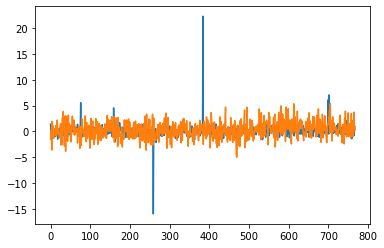

In [28]:
plt.plot(original_reps)
plt.plot(reset_reps)
# plt.plot(resample_reps)

In [13]:
from sequence_models.pretrained import load_model_and_alphabet

original_model, collater = load_model_and_alphabet('carp_600k')

seqs = [['MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG']]
x = collater(seqs)[0]  # (n, max_len)
original_rep = original_model(x).detach().numpy().mean(axis=1)  # (n, max_len, d_model)
original_rep.shape

(1, 128)

In [14]:
import copy

In [15]:
model = copy.deepcopy(original_model).to(DEVICE)
model = reset_parameters(model)
model.eval()  # disables dropout for deterministic results

reset_reps = model(x).detach().numpy().mean(axis=1)
reset_reps.shape

(1, 128)

In [16]:
model = copy.deepcopy(original_model).to(DEVICE)
model = resample_parameters(model)
model.eval()  # disables dropout for deterministic results

resample_reps = model(x).detach().numpy().mean(axis=1)
resample_reps.shape

(1, 128)

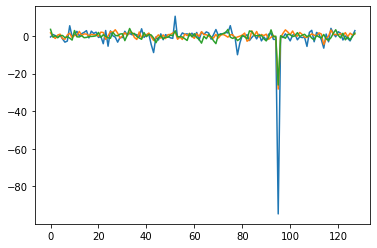

In [17]:
plt.plot(original_rep.T)
plt.plot(reset_reps.T)
plt.plot(resample_reps.T)